<a href="https://colab.research.google.com/github/whkaikai/-python-/blob/main/MLP_smilesVAEversion0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import pandas as pd


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SMILES_COL = "Open Babel SMILES"
TARGET_COL = 'HOMO-LUMO gap'
SMILES_MAXLEN = 50
BATCH_SIZE = 10

In [6]:
df_reg= pd.read_csv('/content/MLPsmiles0.csv')

In [7]:
df_reg[["Open Babel SMILES", "HOMO-LUMO gap"]]

,Open Babel SMILES,HOMO-LUMO gap
0,CN(CCCN1C(=CC(=C[C@@H](C1=O)C)C)C)C,5.064
1,OCc1c(C)cc(cc1C)C,6.041
2,OCc1cc(C)cc(c1O)CO,5.576
3,Oc1ccc(c(c1)C)C(C)C,5.837
4,C/C/1=C\CC(C)(C)/C=C/C/C(=C\CC1)/C,6.229
5,Oc1cc(O)c(c(c1O)C)O,5.124
6,OCc1occ(c(=O)c1)O,5.154
7,Cc1cc2[nH]cnc2cc1C,5.625
8,CC(c1cccc(c1O)C)C,5.984
9,Cc1cc(N)cc(c1N(=O)=O)C,4.250


# Vocab


In [8]:
vocab_freq =  {}
word_length_dist = []
for smile in df_reg[SMILES_COL]:
    for s in smile:
        if s not in vocab_freq.keys():
            vocab_freq[s] = 0
        vocab_freq[s] += 1
    word_length_dist.append(len(smile))

vocab = list(vocab_freq.keys())

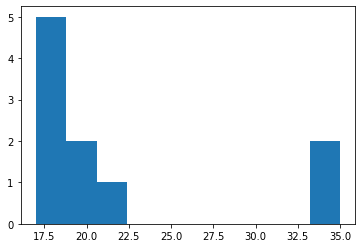

In [9]:
import matplotlib.pyplot as plt

plt.hist(word_length_dist)
plt.show()

# One-hot vector

In [10]:
import numpy as np

def smile2vec(vocab, vecsize, smile):
    vec = []
    for i in range(vecsize):
        v = [0 for _ in range(len(vocab))]
        if i < len(smile):
            v[vocab.index(smile[i])] = 1
        vec += v
    return vec

In [11]:
X = []
for smile in list(df_reg[SMILES_COL]):
    X.append(smile2vec(vocab, SMILES_MAXLEN, smile))

X = np.array(X)

In [12]:
T = list(df_reg[TARGET_COL])
T = np.array(T).reshape(len(T),1)

# 数据拆分

In [13]:
# 奇数番目のデータを教師データ、偶数番目のデータをテストデータとします。
index = np.arange(T.size)
X_train = X[index[index % 2 != 0], :] # 説明変数（教師データ）
X_test = X[index[index % 2 == 0], :] # 説明変数（テストデータ）
T_train = T[index[index % 2 != 0], :] # 目的変数（教師データ）
T_test = T[index[index % 2 == 0], :] # 目的変数（テストデータ）

In [14]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

T_train_tensor = torch.from_numpy(T_train).float()
T_test_tensor = torch.from_numpy(T_test).float()

In [15]:
from torch.utils.data import TensorDataset

train = TensorDataset(X_train_tensor, T_train_tensor)
test = TensorDataset(X_test_tensor, T_test_tensor)

In [17]:
#将批处理数据转换为数据加载器以便于检索
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# MLP model


In [18]:
import torch

class MLPR(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MLPR, self).__init__()
        self.l1 = torch.nn.Linear(n_input, n_hidden)
        self.l2 = torch.nn.Linear(n_hidden, n_hidden)
        self.l3 = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.sigmoid(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        return self.l3(x)

In [19]:
model = MLPR(len(vocab)*SMILES_MAXLEN, 10, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 学习

In [20]:
losses_train = []
losses_test = []
for epoch in range(500):
    total_loss = 0
    for x_train, y_train in train_loader:
        x_train = torch.autograd.Variable(x_train)
        y_train = torch.autograd.Variable(y_train)
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss_test = 0
    for x_test, y_test in test_loader:
        x_test = torch.autograd.Variable(x_test)
        y_test = torch.autograd.Variable(y_test)
        optimizer.zero_grad()
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        total_loss_test += loss.item()

    losses_train.append(total_loss)
    losses_test.append(total_loss_test)
    if (epoch +1) % 100 == 0:
        print("Epoch: {}, Loss (train): {}, Loss (test): {}".format(epoch + 1, total_loss, total_loss_test))

Epoch: 100, Loss (train): 0.37211284041404724, Loss (test): 0.2528666853904724
Epoch: 200, Loss (train): 0.32410821318626404, Loss (test): 0.24216890335083008
Epoch: 300, Loss (train): 0.2742481827735901, Loss (test): 0.23229868710041046
Epoch: 400, Loss (train): 0.2243535816669464, Loss (test): 0.22393126785755157
Epoch: 500, Loss (train): 0.17682969570159912, Loss (test): 0.21749453246593475


# 学习曲线

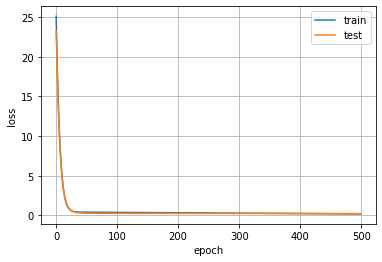

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losses_train, label="train")
plt.plot(losses_test, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

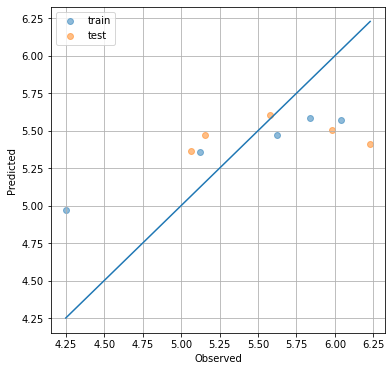

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(T_train, model.forward(X_train_tensor).data.flatten(), alpha=0.5, label="train")
plt.scatter(T_test, model.forward(X_test_tensor).data.flatten(), alpha=0.5, label="test")
plt.plot([min(T), max(T)], [min(T), max(T)])
plt.grid()
plt.legend()
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

# Rdkit

In [23]:
%%time 
!pip install git+https://github.com/maskot1977/rdkit_installer.git
from rdkit_installer import install
install.from_miniconda(rdkit_version="2020.09.1")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/maskot1977/rdkit_installer.git to /tmp/pip-req-build-9xh_h4ax
  Running command git clone -q https://github.com/maskot1977/rdkit_installer.git /tmp/pip-req-build-9xh_h4ax
  Created wheel for rdkit-installer: filename=rdkit_installer-0.2.0-py3-none-any.whl size=7986 sha256=da950f18b503d6c5d8b11156ad903c751325c8ad6957acd620ae8aa6a1335a56
  Stored in directory: /tmp/pip-ephem-wheel-cache-jm3lbld1/wheels/e6/72/a5/218f5f909a3a87c1ec1ccec03ac61298947fb5f1efa517eefa
Successfully built rdkit-installer


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
INFO:rdkit_installer.install:add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.13
INFO:rdkit_installer.install:python version: 3.7.13
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-4.7.12-Linux-x86_64.sh
INFO:rdkit_installer.install:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-4.7.12-Linux-x86_64.sh
done
INFO:rdkit_installer.install:done
installing miniconda to /root/miniconda
INFO:rdkit_installer.install:installing miniconda to /root/miniconda
done
INFO:rdkit_installer.install:done
installing rdkit
INFO:rdkit_installer.install:installing rdkit
done
INFO:rdkit_installer.install:done
rdkit-2020.09.1 installation finished!
INFO:rdkit_installer.install:rdkit-2020.09.1 installation finished!


CPU times: user 868 ms, sys: 321 ms, total: 1.19 s
Wall time: 49.6 s


# MLP-VAE

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
BATCH_SIZE = 64
N_INPUT = len(vocab)*SMILES_MAXLEN
N_HIDDEN = 400
N_Z = 20

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.from_numpy(X).float()
T_tensor = torch.from_numpy(T).float()

dataset = TensorDataset(X_tensor, T_tensor)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
class VAE(torch.nn.Module):
    def __init__(self, n_input=784, n_hidden=400, n_z=20):
        super(VAE, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_z)
        self.fc3 = torch.nn.Linear(n_hidden, n_z)
        self.fc4 = torch.nn.Linear(n_z, n_hidden)
        self.fc5 = torch.nn.Linear(n_hidden, n_input)
        
    def encode(self, x):
        h = torch.nn.functional.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.nn.functional.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [27]:
from rdkit import Chem

def get_best_smile(out_tensor):
    best_smile = ""
    for vec in out_tensor:
        vec = vec.reshape(SMILES_MAXLEN, len(vocab))
        smile = "".join([vocab[torch.argmax(v).item()] for v in vec])
        mol = Chem.MolFromSmiles(smile)
        while not mol:
            if len(smile) == 0: break
            smile = smile[:-1]
            mol = Chem.MolFromSmiles(smile)
        
        if len(best_smile) < len(smile):
            best_smile = smile

    return best_smile

In [28]:
model = VAE(n_input=N_INPUT, n_hidden=N_HIDDEN, n_z=N_Z).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
losses = []
reconst_losses = []
kl_divs = []
for epoch in range(NUM_EPOCHS):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, N_INPUT)
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = torch.nn.functional.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        reconst_losses.append(reconst_loss.item())
        kl_divs.append(kl_div.item())
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, NUM_EPOCHS, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        z = torch.randn(BATCH_SIZE, N_Z).to(device)
        out = model.decode(z)
        print("Epoch[{}/{}], Generated SMILES: {}".format(epoch+1, NUM_EPOCHS, get_best_smile(out)))

        # out, _, _ = model(x)
        # print("Epoch[{}/{}], Reconstructed SMILES: {}".format(epoch+1, NUM_EPOCHS, get_best_smile(out)))

Epoch[1/500], Generated SMILES: NC
Epoch[2/500], Generated SMILES: NC
Epoch[3/500], Generated SMILES: CC
Epoch[4/500], Generated SMILES: NC
Epoch[5/500], Generated SMILES: CC
Epoch[6/500], Generated SMILES: CC
Epoch[7/500], Generated SMILES: OCN
Epoch[8/500], Generated SMILES: Cc1ccc\OcOcc1
Epoch[9/500], Generated SMILES: OCN
Epoch[10/500], Generated SMILES: OCO
Epoch[11/500], Generated SMILES: Oc1ccc\nc(cOc1C)C/N
Epoch[12/500], Generated SMILES: Oc1cccnnc=c(c1C)CC
Epoch[13/500], Generated SMILES: OCc1cccncc(Cc1C)CC
Epoch[14/500], Generated SMILES: Oc1ccc\nc(c(c1C)C)N
Epoch[15/500], Generated SMILES: Oc1ccccnc(OOc1C)CC
Epoch[16/500], Generated SMILES: Oc1cc(C)c(cOc1C)CC
Epoch[17/500], Generated SMILES: Cc1ccc\cc(c(c1C)C)
Epoch[18/500], Generated SMILES: Oc1ccc\cc(c(c1C)C)
Epoch[19/500], Generated SMILES: Oc1cc(C)ccccc1C
Epoch[20/500], Generated SMILES: Oc1cc(Ncc(ccc1C)CC)C
Epoch[21/500], Generated SMILES: Oc1cc(C)c(cCc1C)CC=O
Epoch[22/500], Generated SMILES: OCc1ccNcc(ccc1C)CCO
Epoch[2

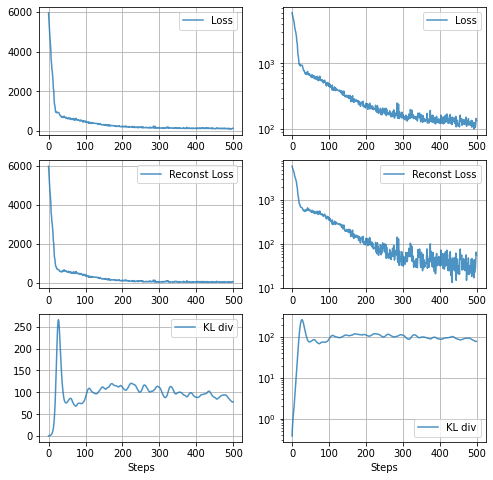

In [30]:
#学习的曲线
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))
plot_data = [losses, reconst_losses, kl_divs]
legends = ["Loss", "Reconst Loss", "KL div"]
for i in range(3):
    axes[i][0].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][0].grid()
    axes[i][0].legend()
    axes[i][1].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][1].grid()
    axes[i][1].legend()
    axes[i][1].set_yscale('log')
axes[2][0].set_xlabel("Steps")
axes[2][1].set_xlabel("Steps")
plt.show()